In [12]:
%load_ext autoreload

# general imports
import numpy as np
import math
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline

# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Gate, Instruction, circuit, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice
from braket.device_schema.device_action_properties import DeviceActionType
import numpy as np

from utils import Plotter, DeviceUtils




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
#non recursive QFT implementation kindly borrowed by braket examples

@circuit.subroutine(register=True)
def qft(qubits):    
    """
    Construct a circuit object corresponding to the Quantum Fourier Transform (QFT)
    algorithm, applied to the argument qubits.  Does not use recursion to generate the QFT.
    
    Args:
        qubits (int): The list of qubits on which to apply the QFT
    """
    qftcirc = Circuit()
    
    # get number of qubits
    num_qubits = len(qubits)
    
    for k in range(num_qubits):
        # First add a Hadamard gate
        qftcirc.h(qubits[k])
    
        # Then apply the controlled rotations, with weights (angles) defined by the distance to the control qubit.
        # Start on the qubit after qubit k, and iterate until the end.  When num_qubits==1, this loop does not run.
        for j in range(1,num_qubits - k):
            angle = 2*math.pi/(2**(j+1))
            qftcirc.cphaseshift(qubits[k+j],qubits[k], angle)
            
    # Then add SWAP gates to reverse the order of the qubits:
    for i in range(math.floor(num_qubits/2)):
        qftcirc.swap(qubits[i], qubits[-i-1])
        
    return qftcirc



@circuit.subroutine(register=True)
def inverse_qft(qubits):
    """
    Construct a circuit object corresponding to the inverse Quantum Fourier Transform (QFT)
    algorithm, applied to the argument qubits.  Does not use recursion to generate the circuit.
    
    Args:
        qubits (int): The list of qubits on which to apply the inverse QFT
    """
    # instantiate circuit object
    qftcirc = Circuit()
    
    # get number of qubits
    num_qubits = len(qubits)
    
    # First add SWAP gates to reverse the order of the qubits:
    for i in range(math.floor(num_qubits/2)):
        qftcirc.swap(qubits[i], qubits[-i-1])
        
    # Start on the last qubit and work to the first.
    for k in reversed(range(num_qubits)):
    
        # Apply the controlled rotations, with weights (angles) defined by the distance to the control qubit.
        # These angles are the negative of the angle used in the QFT.
        # Start on the last qubit and iterate until the qubit after k.  
        # When num_qubits==1, this loop does not run.
        for j in reversed(range(1, num_qubits - k)):
            angle = -2*math.pi/(2**(j+1))
            qftcirc.cphaseshift(qubits[k+j],qubits[k], angle)
            
        # Then add a Hadamard gate
        qftcirc.h(qubits[k])
    
    return qftcirc


# apply id or sigmax to obtain a definite integer as input
# (in binary representation)
@circuit.subroutine(register=True)
def integer_input(qubits, x):
    # instantiate circuit object
    circ = Circuit()
    
    # get number of qubits
    num_qubits = len(qubits)

    #must be able to represent input
    assert x < 2**num_qubits
    bitstring = format(x, "0"+ str(num_qubits) +"b")

    #print(bitstring)

    #todo: need to reverse iteration(?)
    for i in range(num_qubits):
        if bitstring[i] == "1" :
            circ.x(qubits[i])


    return circ

#get special state preimage of a defined integer for qft
@circuit.subroutine(register=True)
def transformed_input(qubits, x = 0):

    # get number of qubits
    num_qubits = len(qubits)

    circ = Circuit()

    circ.h(qubits)
    for ii in range(num_qubits - 1):
        circ.rz(ii+1, math.pi/(2**ii))

    return circ




In [17]:


# show inverse QFT example circuit
num_qubits = 3
qubits=range(num_qubits)
my_qft_circ = qft(qubits)
print('QFT CIRCUIT:')
print(my_qft_circ)

# show inverse QFT example circuit
print('')
print('INVERSE-QFT CIRCUIT:')
my_iqft_circ = inverse_qft(qubits)
print(my_iqft_circ)



QFT CIRCUIT:
T  : |0|     1     |      2      |     3     |4| 5  |
                                                     
q0 : -H-PHASE(1.57)-PHASE(0.79)-----------------SWAP-
        |           |                           |    
q1 : ---C-----------|-----------H-PHASE(1.57)---|----
                    |             |             |    
q2 : ---------------C-------------C-----------H-SWAP-

T  : |0|     1     |      2      |     3     |4| 5  |

INVERSE-QFT CIRCUIT:
T  : | 0  |1|     2      |      3       |     4      |5|
                                                        
q0 : -SWAP------------------PHASE(-0.79)-PHASE(-1.57)-H-
      |                     |            |              
q1 : -|------PHASE(-1.57)-H-|------------C--------------
      |      |              |                           
q2 : -SWAP-H-C--------------C---------------------------

T  : | 0  |1|     2      |      3       |     4      |5|


8
Counter({'11111110': 100})


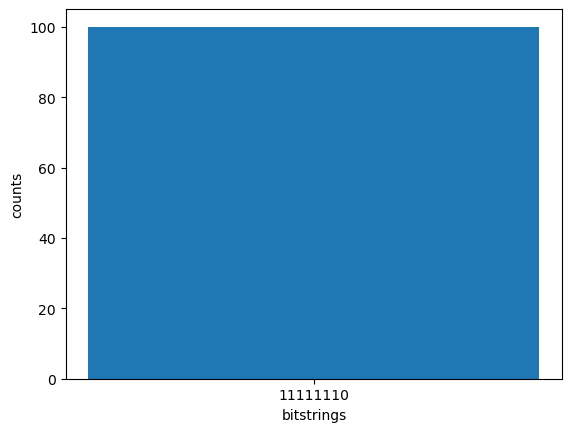

In [16]:
device = LocalSimulator()

x = 2
qbits = 8
print(qbits)

circ = transformed_input(range(qbits)).qft( range(qbits))

result = device.run(circ, shots = 100).result()

Plotter.plot_binary_results(result, debug=True)

In [91]:
#Rigetti AspenM2
device = DeviceUtils.get_device("rigetti")

qft_task = device.run(circ, shots = 100)



In [50]:
#bigger rigetti
device = DeviceUtils.get_device("rigetti")

x = 2
qbits = 4
print(qbits)

circ = transformed_input(range(qbits)).qft( range(qbits))

qft6_rigetti = device.run(circ, shots = 1000)
print(qft6_rigetti._arn)

4
arn:aws:braket:us-west-1:058017682654:quantum-task/034cb3e9-0628-440d-a13b-69b453254abd


In [117]:
#IonQ
device = DeviceUtils.get_device("ionq")

ion_qft_task = device.run(circ, shots = 100)

ValidationException: An error occurred (ValidationException) when calling the CreateQuantumTask operation: [line 10] uses a gate: cphaseshift which is not supported by the device or defined via a defcal

In [65]:
#Lucy
device = DeviceUtils.get_device("oqc")

oqc_qft_task = device.run(circ, shots = 1000)

In [48]:
%load_ext autoreload
%autoreload 2

from utils import BraketTaskScanner

lucy_task = "arn:aws:braket:eu-west-2:058017682654:quantum-task/bc9dacfa-823e-4b8f-81a7-54e51588af99"
aspen_10 = "arn:aws:braket:us-west-1:058017682654:quantum-task/00e27411-115c-404c-b586-2a3c5da198ec"
aspen_8 = "arn:aws:braket:us-west-1:058017682654:quantum-task/14cb4635-c75d-463d-a4e4-c3d74a4e0686"
aspen_6 = "arn:aws:braket:us-west-1:058017682654:quantum-task/3fcb3e03-5eea-407e-89d6-354faf00b160"
aspen_5 = "arn:aws:braket:us-west-1:058017682654:quantum-task/0ea84501-f757-470a-ba40-875bf3b7ee87"
aspen_4 = "arn:aws:braket:us-west-1:058017682654:quantum-task/034cb3e9-0628-440d-a13b-69b453254abd"
aspen_3 = "arn:aws:braket:us-west-1:058017682654:quantum-task/a0f298f3-b2dd-448d-9223-bf1e22305a6a" 

scanner = BraketTaskScanner(lucy_task)
scanner_aspen = BraketTaskScanner(aspen_6)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


COMPLETED
True
ONLINE
1.3500000000
0.3350000000
Counter({'010': 19, '000': 18, '110': 18, '100': 12, '101': 12, '011': 10, '111': 6, '001': 5})


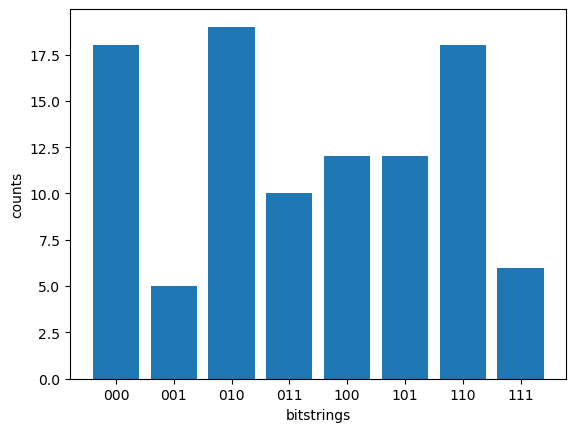

12.5 100 100.0 8


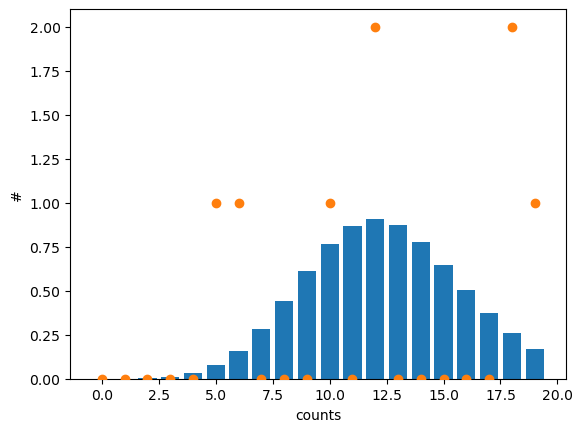

Normalized chi quared for results statistics: 2.3771428571428572


False

In [46]:
print( scanner.get_status())
print( scanner.results_available())
print( scanner.get_device_status())

#print(scanner.get_circuit())
#print(scanner_aspen.get_circuit())
print(scanner_aspen.cost_extimate())
print(scanner.cost_extimate())

Plotter.plot_binary_results(scanner.get_results(), debug=True)
Plotter.plot_results_statistic(scanner.get_results())
scanner.is_garbage()

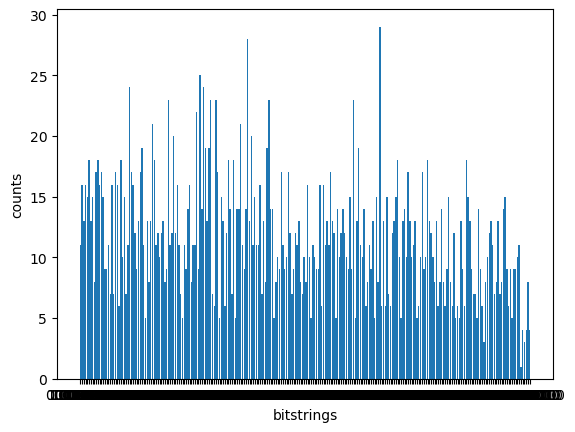

11.71875 3000 3000.0 256


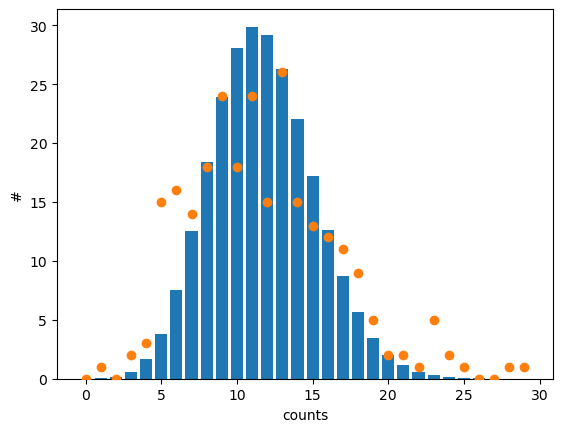

Normalized chi quared for results statistics: 1.9916967320261458


True

In [44]:
Plotter.plot_binary_results(scanner_aspen.get_results(), debug=False)
Plotter.plot_results_statistic(scanner_aspen.get_results())

scanner_aspen.is_garbage()